### Title

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import patsy
import statsmodels.api as sm
import warnings
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
from statsmodels.formula.api import ols

from statsmodels.tsa.seasonal import seasonal_decompose
from collections import defaultdict
df = pd.read_excel('../data/tech_layoffs.xlsx')

df = df.drop(columns=['Company'])
df['Funding'] = df['Money_Raised_in_$_mil'].apply(lambda s: np.float64(s[1:])) 
df['Money_Raised_in_$_mil'] = df['Money_Raised_in_$_mil'].apply(lambda s: np.float64(s[1:])) 
df["Date_layoffs"] = df['Date_layoffs'].apply(lambda i: pd.to_datetime(str(i).split()[0], format="%Y-%d-%m") if i >= pd.to_datetime("2024-01-01", format="%Y-%d-%m") else i)

Let's first look at how the layoff rate of companies changes per year. In our dataset we have the years 2020-2024. The data for 2024 is lacking as our dataset only includes up until January 2024, but as we are looking at the percentage rate of layoffs it shouldn't matter too much.

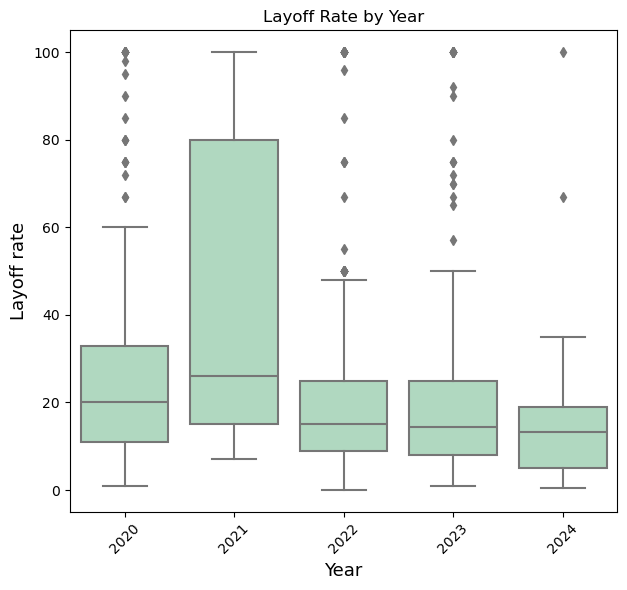

In [64]:
plt.figure(figsize=(12, 6))

# layoff rate
plt.subplot(1, 2, 1)
sns.boxplot(x='Year', y='Percentage', data=df, color = '#A9DFBF')
plt.title('Layoff Rate by Year')
plt.xlabel('Year', fontsize = 13)
plt.ylabel('Layoff rate', fontsize = 13)
plt.xticks(rotation = 45)


plt.tight_layout()
plt.show()

As demonstrated in the above plot, 2021 has the highest mean layoff rate, however, there is also a much broader interquartile range. This graphic illustrates that 2021 has the greatest variability, which proceeds to decrease and stabilize from 2022 onwards. To attempt to understand this finding, we can take a little look into the data. 

In [65]:
df[["Year", "Percentage"]].groupby("Year").describe()

Percentage                                                              
          count       mean        std       min   25%        50%   75%    max
Year                                                                         
2020      333.0  27.071795  22.930779  1.000000  11.0  20.000000  33.0  100.0
2021       14.0  43.212625  37.662511  6.976744  15.0  26.000000  80.0  100.0
2022      579.0  20.535096  19.213116  0.044980   9.0  15.000000  25.0  100.0
2023      476.0  19.340076  18.839122  0.996165   8.0  14.500000  25.0  100.0
2024       16.0  21.304078  26.456557  0.531915   5.0  13.166667  19.0  100.0

Looking at a basic analysis of our data, we can see that 2021 and 2024 both are lacking in data points, with 2021 having the least at 14 layoff events. As a result we should be cautious about drawing conclusions based upon 2021 and 2024. 

We are going to do a time series analysis of our data. We aim to look at the correlation between time and the number of layoffs, specifically layoffs over the general period and trends based upon the month of the year. To do this, the data for our layoffs is first cleaned and then put into a seasonal decomposition with month-long buckets. From this, we can view the overall trend over the time period and also the "seasonal" effect the month has on the number of layoffs.

In [48]:
# obtain relevant columns
time_series_df = df[["Laid_Off", "Company_Size_before_Layoffs", "Company_Size_after_layoffs", "Date_layoffs", "Percentage"]]

# aggregate dates if duplicate, sum
time_series_df = time_series_df.groupby("Date_layoffs").agg(["count", "sum"])

# flatten multi index to normal
time_series_df.columns = time_series_df.columns.to_flat_index()
# make sensical names
time_series_df.columns = ["_".join(i) for i in time_series_df.columns]

# put 0 values in place of NaN
time_series_df = time_series_df.resample('MS').sum()

time_series_df["Laid_Off_mean"] = time_series_df["Laid_Off_sum"]/time_series_df["Laid_Off_count"]
time_series_df["Percentage_mean"] = time_series_df["Percentage_sum"]/time_series_df["Percentage_count"]

# put 0 values in place of NaN
time_series_df = time_series_df.resample('MS').sum()

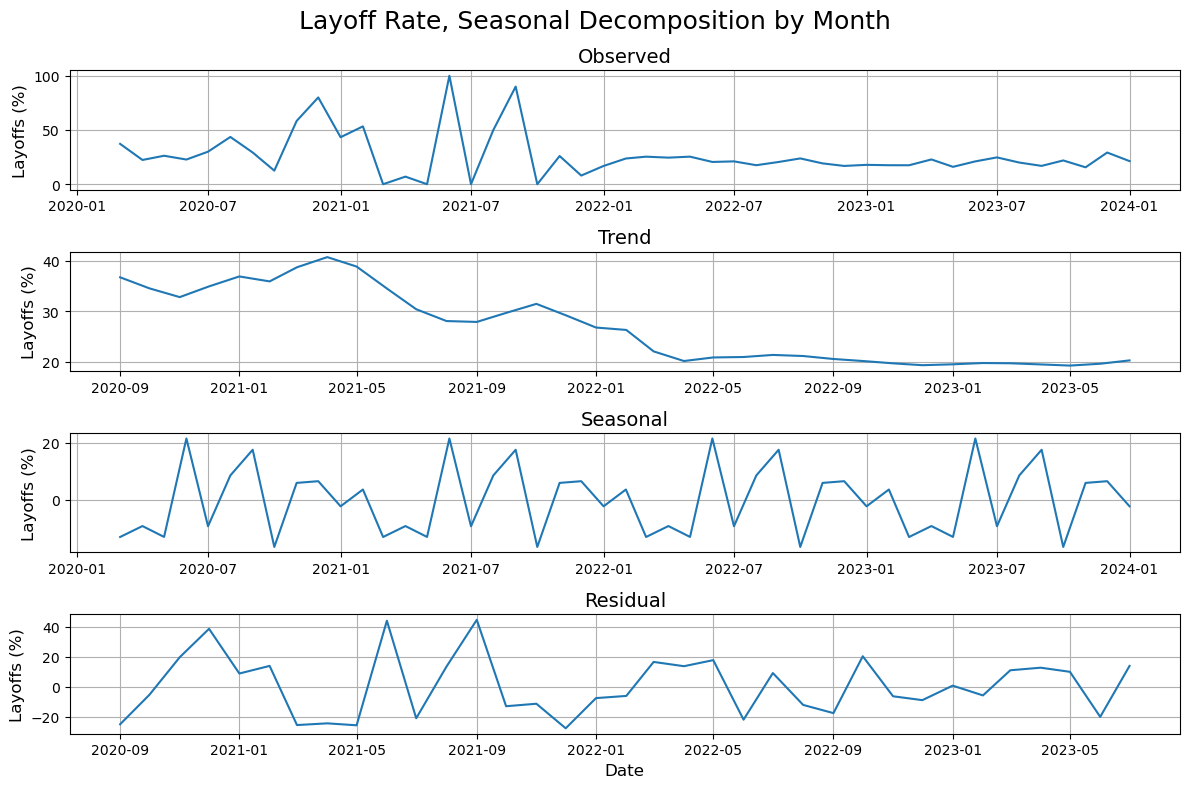

In [49]:
result = seasonal_decompose(time_series_df['Percentage_mean'], model='additive', period=12)

ylabel = "Layoffs (%)"

### begin plots ###
plt.figure(figsize=(12, 8))

plt.suptitle("Layoff Rate, Seasonal Decomposition by Month", fontsize = 18)

# observed
plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.title('Observed', fontsize=14)
plt.ylabel(ylabel, fontsize=12)
plt.grid(True)

# trend
plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.title('Trend', fontsize=14)
plt.ylabel(ylabel, fontsize=12)
plt.grid(True)

# seasonal
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.title('Seasonal', fontsize=14)
plt.ylabel(ylabel, fontsize=12)
plt.grid(True)

# residual
plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.title('Residual', fontsize=14)
plt.ylabel(ylabel, fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

As a result of the seasonal decomposition we have the data decomposed into three components. We can think of each graph like this: `observed = trend + seasonal + residual`. The "trend" component will show a sort of smoothed idea of how the data changes over time. The "seasonal" component is cyclic and yearly -- it looks to describe purely the effect that each month will have on the total layoffs. The "residual" component shows unexpected and unexplained things in the data.

The trend line illustrates a significant increase in percentage layoffs starting early 2020 until its peak in spring 2021, where it then begins to slowly decrease until hitting a low in spring 2022. The seasonal line shows an annual pattern, suggesting a seasonal effect on layoffs. It shows a large amount of inconsistencies in percentage layoffs per month, with the most laid off months being June and September. We can perhaps attribute these two large layoff periods to the ending of their respective fiscal quarters Q2 and Q3; companies who have performed poorly may decide to downsize. The residual plot, which is typically used for identifying anomalies and irregularities in data, peaks in December 2020, June 2021, and September 2021, indicating possible unexpected or anomalous events that caused layoff rates to deviate from their typical trends.

As mentioned above, the dataset is lacking data points for 2021, and as a result there are certain months in 2021 with no layoffs recorded whatsoever.

We would like to investigate whether or not there is a yearly pattern that can be found for layoffs in our dataset. In this case, we will be looking to see if the fiscal quarter, month, or day have any effect on how many layoffs are occurring. 

$ H_0: $ There is not a statistically significant correlation between `Quarter`, `Month`, `Day` and the `Percentage` of layoffs. 

$ H_1: $ There is a statistically significant correlation between `Quarter`, `Month`, `Day` and the `Percentage` of layoffs. 

We will consider $ p > 0.05 $ to be the requirement for a variable to be a statistically significant indicator of layoffs.

In [46]:
# TODO: Perform 1 stats test (don't print entire output of a model, only the p-value)
# regression analysis 
df["Quarter"] = df["Date_layoffs"].apply(lambda i: (int(str(i).split()[0].split("-")[1])+2) // 3)
df["Month"] = df["Date_layoffs"].apply(lambda i: int(str(i).split()[0].split("-")[1]))
df["Day"] = df["Date_layoffs"].apply(lambda i: int(str(i).split()[0].split("-")[2]))

X = df[["Year", "Month", "Quarter", "Day"]]
X = sm.add_constant(X) 
y = df['Percentage']

# regression model
model = sm.OLS(y, X).fit()
#model_summary = model.summary()
#print(model_summary)
model.pvalues

const      2.364107e-08
Year       2.701361e-08
Month      3.871946e-01
Quarter    2.824362e-01
Day        2.547686e-01
dtype: float64

From our linear regression above, we can see that there is a statistically significant effect that the "Year" has on the number of employees laid off at $p == 0.000$. Meanwhile, there are statistically insignificant effects from "Month" ($p == 0.387$), "Quarter" ($p == 0.282$), and "Day" ($p == 0.255$), suggesting that the overall time period is what affects the number of employees laid off as opposed to the cyclical periods within the year. 

We can conclude that there is no seasonal correlation between moments in a year to the percentage of layoffs that occur, meaning that we can accept our null hypothesis. 